# Example usage of the ofset free koopman MPC

In [1]:
import sys
import os
import numpy as np
#import pandas as pd
import joblib
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torch
from sklearn.preprocessing import StandardScaler

from neuromancer.system import Node, System
from neuromancer.trainer import Trainer
from neuromancer.problem import Problem
from neuromancer.dataset import DictDataset
from neuromancer.constraint import variable
from neuromancer.loss import PenaltyLoss
from neuromancer. modules import blocks

# Add 'src' to Python path
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
src_path = os.path.join(project_root, 'src')
sys.path.append(src_path)

import models
import helper
%load_ext autoreload
%autoreload 2

Models imported succesfully
Helper imported succesfully


## Creating a Dataset

In [2]:
# Instantiate CSTR series with recycle model
CSTR = models.CSTRSeriesRecycle()

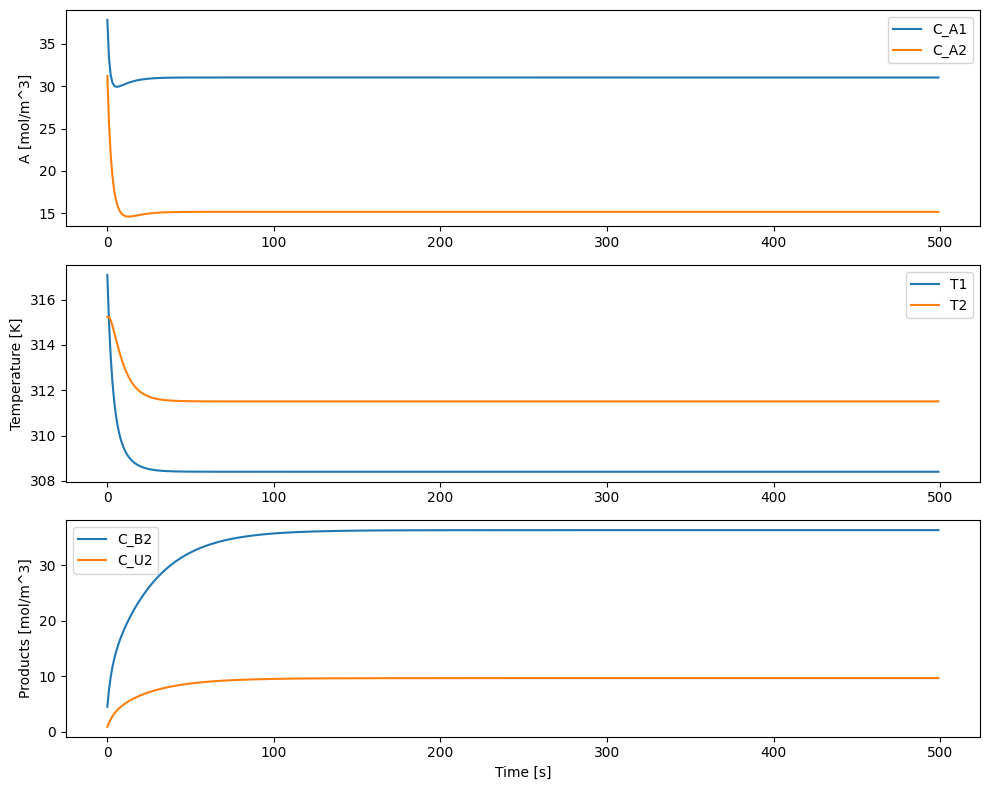

In [3]:
# example simulation
sim_time = 500
Ts = 1
# initial states [C_A1, T1, C_A2, T2, C_B1, C_B2, C_U1, C_U2]
C_A1_0, T1_0, C_A2_0, T2_0 = 50.0, 320.0, 40.0, 315.0
C_B1_0, C_B2_0, C_U1_0, C_U2_0 = 0.0, 0.0, 0.0, 0.0
x0 = [C_A1_0, T1_0, C_A2_0, T2_0, C_B1_0, C_B2_0, C_U1_0, C_U2_0]
# inputs [F, L, Tc1, Tc2]
u = np.ones((sim_time, 4))
u[:, 0] = 1e-4   # F
u[:, 1] = 1e-4   # L
u[:, 2] = 315.0  # Tc1
u[:, 3] = 315.0  # Tc2

sim = CSTR.simulate(x0, u, Ts)
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.subplot(3, 1, 1)
plt.plot(sim['Y'][:, 0], label='C_A1')
plt.plot(sim['Y'][:, 2], label='C_A2')
plt.ylabel('A [mol/m^3]')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(sim['Y'][:, 1], label='T1')
plt.plot(sim['Y'][:, 3], label='T2')
plt.ylabel('Temperature [K]')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(sim['Y'][:, 5], label='C_B2')
plt.plot(sim['Y'][:, 7], label='C_U2')
plt.ylabel('Products [mol/m^3]')
plt.xlabel('Time [s]')
plt.legend()

plt.tight_layout()
plt.show()


In [4]:
import scipy.optimize

def find_steady_state(model, u, x0=None, tol=1e-8, maxiter=1000):
    """
    Finds the steady state x_ss for the given model and constant input u.
    
    Parameters
    ----------
    model : Model instance
        The dynamic model (must have .ode(t, x) and .Ts attributes).
    u : array-like
        Constant input vector for which to find the steady state.
    x0 : array-like or None
        Initial guess for the state. If None, uses default near-feed guess.
    tol : float
        Tolerance for the steady-state solver.
    maxiter : int
        Maximum number of iterations for the solver.
        
    Returns
    -------
    x_ss : np.ndarray
        Steady-state state vector.
    """
    # Set the model's input data to a constant input
    model.u_data = np.atleast_2d(u)
    model.Ts = 1.0  # dummy sampling time for get_input

    # State dimension: use model by simulating one step from a guess
    if x0 is None:
        # default initial guess close to feed, zeros for products
        x0 = np.array([model.C_A_O, model.T_O, model.C_A_O, model.T_O, 0.0, 0.0, 0.0, 0.0], dtype=float)
    
    def residual(x):
        # ODE at steady state: dx/dt = 0
        return np.array(model.ode(0, x))
    
    sol = scipy.optimize.root(residual, x0, method='hybr', tol=tol, options={'maxfev': maxiter})
    if not sol.success:
        print("Warning: Steady-state solver did not converge:", sol.message)
    return sol.x

# Example usage:
steady_u = [1e-4, 1e-4, 300.0, 300.0]  # [F, L, Tc1, Tc2]
x_ss = find_steady_state(CSTR, steady_u)
print("Steady-state x:", x_ss)


Steady-state x: [ 38.38272973 299.09381862  22.57988549 299.46534065  27.74578153
  34.9642864    3.60788816   4.97372266]


### Step changes and simulation

In [5]:
# constraints for inputs [F, L, Tc1, Tc2]
constraints = np.array([
    [0, 2e-4],   # F range [m^3/s]
    [0, 2e-4],   # L range [m^3/s]
    [280.0, 330.0], # Tc1 [K]
    [280.0, 330.0], # Tc2 [K]
])
step_time = 100
no_steps = 100
steps = helper.generate_steps(step_time, no_steps, constraints)

In [6]:
Ts = 1
# initial states [C_A1, T1, C_A2, T2, C_B1, C_B2, C_U1, C_U2]
C_A1_0, T1_0, C_A2_0, T2_0 = 50.0, 320.0, 40.0, 315.0
C_B1_0, C_B2_0, C_U1_0, C_U2_0 = 0.0, 0.0, 0.0, 0.0
x0 = [C_A1_0, T1_0, C_A2_0, T2_0, C_B1_0, C_B2_0, C_U1_0, C_U2_0]

sim = CSTR.simulate(x0, steps, Ts)

In [7]:
# add noise to sim data

add_noise = False
if add_noise:
    # add noise to the simulation data
    # set random seed for reproducibility
    np.random.seed(42)
    noise = np.random.normal(0, 0.02, sim["Y"].shape)
    sim["Y"] += noise

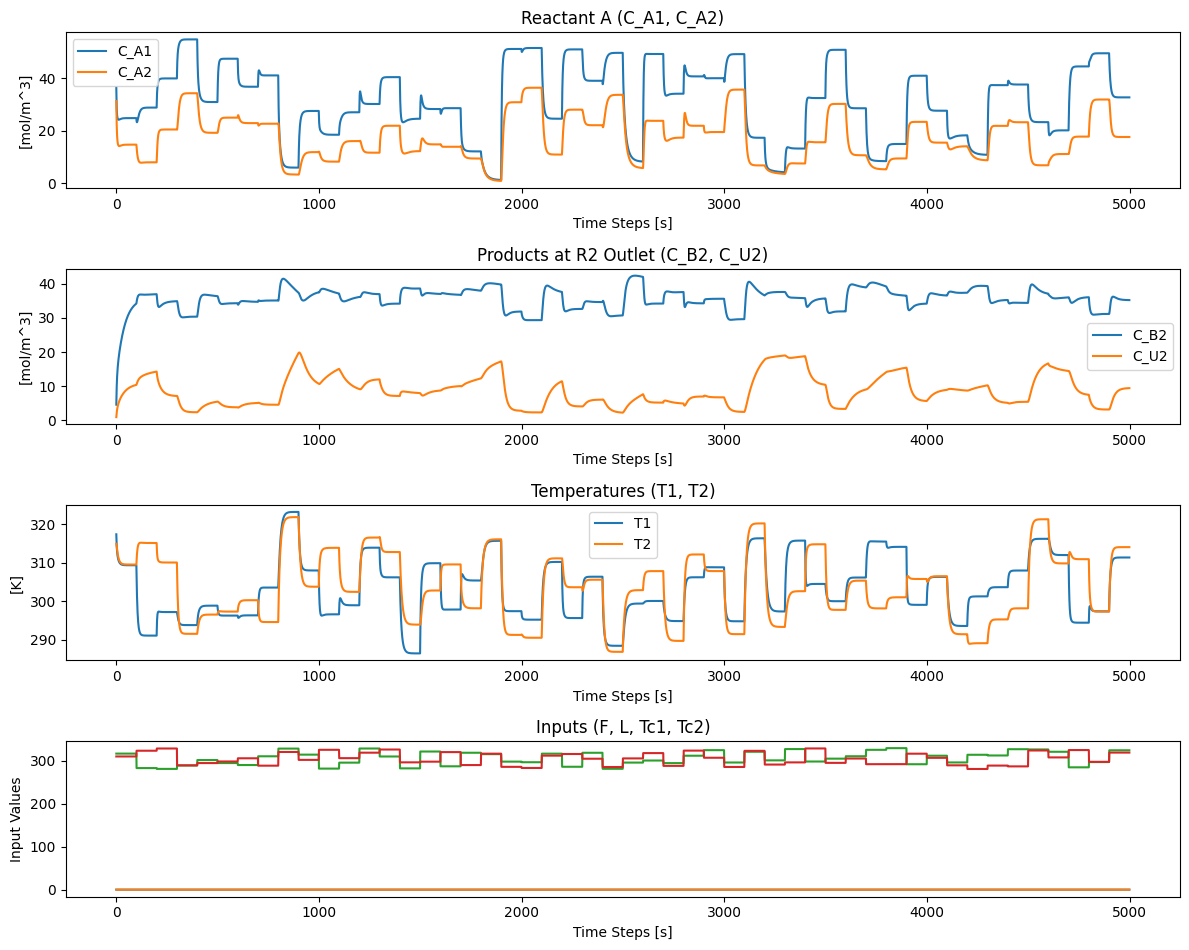

In [8]:
part = 5000

plt.figure(figsize=(12, 10))

plt.subplot(4, 1, 1)
plt.plot(sim["Y"][:part, [0, 2]], label=["C_A1", "C_A2"])
plt.title("Reactant A (C_A1, C_A2)")
plt.xlabel("Time Steps [s]")
plt.ylabel("[mol/m^3]")
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(sim["Y"][:part, [5, 7]], label=["C_B2", "C_U2"])
plt.title("Products at R2 Outlet (C_B2, C_U2)")
plt.xlabel("Time Steps [s]")
plt.ylabel("[mol/m^3]")
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(sim["Y"][:part, [1, 3]], label=["T1", "T2"])
plt.title("Temperatures (T1, T2)")
plt.xlabel("Time Steps [s]")
plt.ylabel("[K]")
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(sim["U"][:part])
plt.title("Inputs (F, L, Tc1, Tc2)")
plt.xlabel("Time Steps [s]")
plt.ylabel("Input Values")

plt.tight_layout(rect=[0, 0, 1, 0.96])

## Preparing data for training koopman models

In [9]:
def get_data(train_sim, dev_sim, test_sim, nsteps, bs, scaler, scalerU):
    
    ny = train_sim['Y'].shape[1]
    nu = train_sim['U'].shape[1]
    
    nsim = train_sim['Y'].shape[0]
    nbatch = nsim//nsteps
    length = (nsim//nsteps) * nsteps

    trainX = scaler.transform(train_sim['Y'][:length])
    trainX = trainX.reshape(nbatch, nsteps, ny)
    trainX = torch.tensor(trainX, dtype=torch.float32)
    trainU = scalerU.transform(train_sim['U'][:length])
    trainU = trainU.reshape(nbatch, nsteps, nu)
    trainU = torch.tensor(trainU, dtype=torch.float32)
    train_data = DictDataset({'Y': trainX, 'Y0': trainX[:, 0:1, :],
                              'U': trainU}, name='train')
    train_loader = DataLoader(train_data, batch_size=bs,
                              collate_fn=train_data.collate_fn, shuffle=True)
    
    nsim = dev_sim['Y'].shape[0]
    nbatch = nsim//nsteps
    length = (nsim//nsteps) * nsteps
    
    devX = scaler.transform(dev_sim['Y'][:length])
    devX = devX.reshape(nbatch, nsteps, ny)
    devX = torch.tensor(devX, dtype=torch.float32)
    devU = scalerU.transform(dev_sim['U'][:length])
    devU = devU[:length].reshape(nbatch, nsteps, nu)
    devU = torch.tensor(devU, dtype=torch.float32)
    dev_data = DictDataset({'Y': devX, 'Y0': devX[:, 0:1, :],
                            'U': devU}, name='dev')
    dev_loader = DataLoader(dev_data, batch_size=bs,
                            collate_fn=dev_data.collate_fn, shuffle=True)

    nsim = test_sim['Y'].shape[0]
    nbatch = nsim//nsteps
    length = (nsim//nsteps) * nsteps
    
    testX = scaler.transform(test_sim['Y'][:length])
    testX = testX.reshape(1, nbatch*nsteps, ny)
    testX = torch.tensor(testX, dtype=torch.float32)
    testU = scalerU.transform(test_sim['U'][:length])
    testU = testU.reshape(1, nbatch*nsteps, nu)
    testU = torch.tensor(testU, dtype=torch.float32)
    test_data = {'Y': testX, 'Y0': testX[:, 0:1, :],
                 'U': testU}
    
    trainX = scaler.transform(train_sim['Y'][:length])
    trainX = trainX.reshape(1, nbatch*nsteps, ny)
    trainX = torch.tensor(trainX, dtype=torch.float32)
    trainU = scalerU.transform(train_sim['U'][:length])
    trainU = trainU.reshape(1, nbatch*nsteps, nu)
    trainU = torch.tensor(trainU, dtype=torch.float32)
    train_data_forC = {'Y': trainX, 'Y0': trainX[:, 0:1, :],
                 'U': trainU}

    return train_loader, dev_loader, test_data, train_data_forC

In [10]:
train_sim = {key: value[:5000] for key, value in sim.items()}
test_sim = {key: value[7000:] for key, value in sim.items()}
dev_sim = {key: value[5000:7000] for key, value in sim.items()}

nsteps = 80   # number of prediction horizon steps in the loss function
bs = 80      # minibatching batch size

In [11]:
# fit and save scalers for scaling the data on train dataset
scaler = StandardScaler()
scaler.fit(train_sim['Y'])  
joblib.dump(scaler, '../data/scaler.pkl')

scalerU = StandardScaler()
scalerU.fit(train_sim['U'])
joblib.dump(scalerU, '../data/scalerU.pkl')


['../data/scalerU.pkl']

In [12]:
train_loader, dev_loader, test_data, train_data = get_data(train_sim, dev_sim, test_sim, nsteps, bs, scaler, scalerU)

## Creating the model


In [13]:
# model parameters
nz = 24
ny = train_sim['Y'].shape[1]
nu = train_sim['U'].shape[1]

layers = [40,80,120]
layers_dec  = [120,80,40]

matrix_C = False

In [14]:
# instantiate output encoder neural net f_y
f_y = blocks.MLP(
    ny,
    nz,
    bias=True,
    linear_map=torch.nn.Linear,
    nonlin=torch.nn.ReLU,
    hsizes=layers,
)
# initial condition encoder
encode_Y0 = Node(f_y, ['Y0'], ['x'], name='encoder_Y0')
# observed trajectory encoder
encode_Y = Node(f_y, ['Y'], ['x_latent'], name='encoder_Y')

In [15]:
# instantiate input encoder net f_u, representing the B matrix in the linear system
f_u = torch.nn.Linear(nu, nz, bias=False)
# initial condition encoder
encode_U = Node(f_u, ['U'], ['u_latent'], name='encoder_U')

In [16]:
# instantiate state decoder neural net f_y_inv
if not matrix_C:
    f_y_inv = blocks.MLP(nz, ny, bias=True,
                    linear_map=torch.nn.Linear,
                    nonlin=torch.nn.ELU,
                    hsizes=layers_dec)
elif matrix_C:
    f_y_inv = torch.nn.Linear(nz, ny, bias=False)
else:
    raise ValueError('matrix_C must be boolean')

# predicted trajectory decoder
decode_y = Node(f_y_inv, ['x'], ['yhat'], name='decoder_y')

In [17]:
# representing matrix A in the linear system
K = torch.nn.Linear(nz, nz, bias=False)

In [18]:
# symbolic Koopman model with control inputs
Koopman = Node(helper.PredictionWControl(K), ['x', 'u_latent'], ['x'], name='K')

# latent Koopmann rollout
dynamics_model = System([Koopman], name='Koopman', nsteps=nsteps)

In [19]:
# put all nodes of the Koopman model together in a list of nodes
nodes = [encode_Y0, encode_Y, encode_U, dynamics_model, decode_y]

### Define Koopman system identification loss function terms

In [20]:
# variables
Y = variable("Y")  # observed
yhat = variable('yhat')  # predicted output
x_latent = variable('x_latent')  # encoded output trajectory in the latent space
u_latent = variable('u_latent')  # encoded input trajectory in the latent space
x = variable('x')  # Koopman latent space trajectory

xu_latent = x_latent + u_latent  # latent state trajectory

# output trajectory tracking loss
y_loss = 10. * (yhat[:, 1:-1, :] == Y[:, 1:, :]) ^ 2
y_loss.name = "y_loss"

# one-step tracking loss
onestep_loss = 1.*(yhat[:, 1, :] == Y[:, 1, :])^2
onestep_loss.name = "onestep_loss"

# reconstruction loss
reconstruction_loss = 20.*(yhat[:, 0, :] == Y[:, 0, :])^2
reconstruction_loss.name = "reconstruction_loss"

# latent trajectory tracking loss
x_loss = 1. * (x[:, 1:-1, :] == xu_latent[:, 1:, :]) ^ 2
x_loss.name = "x_loss"

### Construct System learning problem

In [21]:
# aggregate list of objective terms and constraints
objectives = [y_loss, x_loss, onestep_loss, reconstruction_loss]

# create constrained optimization loss
loss = PenaltyLoss(objectives, constraints=[])

# construct constrained optimization problem
problem = Problem(nodes, loss)

In [22]:
problem.nodes

ModuleList(
  (0): encoder_Y0(Y0) -> x
  (1): encoder_Y(Y) -> x_latent
  (2): encoder_U(U) -> u_latent
  (3): System(
    (nodes): ModuleList(
      (0): K(x, u_latent) -> x
    )
  )
  (4): decoder_y(x) -> yhat
)

### Solve the problem

In [23]:
optimizer = torch.optim.Adam(problem.parameters(), lr=0.001)

trainer = Trainer(
    problem,
    train_loader,
    dev_loader,
    test_data,
    optimizer,
    patience=400,
    warmup=500,
    epochs=5000,
    eval_metric="dev_loss",
    train_metric="train_loss",
    dev_metric="dev_loss",
    test_metric="dev_loss",
)


In [24]:
# train

best_model = trainer.train()
problem.load_state_dict(best_model)


epoch: 0  train_loss: 35.50182342529297
epoch: 1  train_loss: 35.013973236083984
epoch: 2  train_loss: 34.54261779785156
epoch: 3  train_loss: 34.06180191040039
epoch: 4  train_loss: 33.5481071472168
epoch: 5  train_loss: 32.97782516479492
epoch: 6  train_loss: 32.32712936401367
epoch: 7  train_loss: 31.570758819580078
epoch: 8  train_loss: 30.680749893188477
epoch: 9  train_loss: 29.630884170532227
epoch: 10  train_loss: 28.39975929260254
epoch: 11  train_loss: 26.97811508178711
epoch: 12  train_loss: 25.373506546020508
epoch: 13  train_loss: 23.624618530273438
epoch: 14  train_loss: 21.81292724609375
epoch: 15  train_loss: 20.066049575805664
epoch: 16  train_loss: 18.549129486083984
epoch: 17  train_loss: 17.42236328125
epoch: 18  train_loss: 16.754886627197266
epoch: 19  train_loss: 16.433988571166992
epoch: 20  train_loss: 16.192096710205078
epoch: 21  train_loss: 15.775422096252441
epoch: 22  train_loss: 15.111590385437012
epoch: 23  train_loss: 14.314388275146484
epoch: 24  train

<All keys matched successfully>

### Saving model and evaluation of the training

In [25]:
# save model
torch.save(best_model, "../data/model_C_" + str(matrix_C) + ".pth")

# pull matrices
A = K.weight.detach().numpy()
B = f_u.weight.detach().numpy()
if matrix_C:
    C = f_y_inv.weight.detach().numpy()
    
elif not matrix_C:
    # get approximate C matrix from training data
    problem.nodes[3].nsteps = train_data['Y'].shape[1]
    train_outputs = problem.step(train_data)

    Y = train_data['Y'].reshape(-1, ny).detach().numpy()
    Z = train_outputs['x'][:,:-1,:].detach().numpy().reshape(-1, nz)
    rankZ = np.linalg.matrix_rank(Z)
    if rankZ < nz:
        print('Rank deficient Z matrix, can result in bad fitted C matrix!')
    C, residuals, rank, s = np.linalg.lstsq(Z, Y, rcond=None)
    C = C.T

else:
    raise ValueError('matrix_C must be boolean')

In [26]:
from numpy.linalg import matrix_rank

# Compute the controllability matrix
n_states = A.shape[0]
controllability_matrix = np.hstack([np.linalg.matrix_power(A, i) @ B for i in range(n_states)])

# Check the rank of the controllability matrix
controllability_rank = matrix_rank(controllability_matrix)

print(f"Controllability Matrix Rank: {controllability_rank}")
print(f"System is {'controllable' if controllability_rank == n_states else 'not controllable'}")

Controllability Matrix Rank: 24
System is controllable


In [27]:
# # Evaluate Jacobian for each latent state
# J_all = np.stack([
#     helper.evaluate_jacobian(problem.nodes[4], torch.from_numpy(xi).float())
#     for xi in x_train
# ])

# # Compute mean Jacobian
# C = np.mean(J_all, axis=0)
# print("Mean Jacobian J_mean:\n", C) # mean bias?

In [28]:
np.save('../data/A_C_' + str(matrix_C) + '.npy', A)
np.save('../data/B_C_' + str(matrix_C) + '.npy', B)
np.save('../data/C_C_' + str(matrix_C) + '.npy', C)

In [29]:
# update the rollout length based on the test data
problem.nodes[3].nsteps = test_data['Y'].shape[1]

In [30]:
# do the prediction
test_outputs = problem.step(test_data)

pred_traj = test_outputs['yhat'][:, 1:-1, :].detach().numpy().reshape(-1, ny).T
true_traj = test_data['Y'][:, 1:pred_traj.shape[1]+1, ].detach().numpy().reshape(-1, ny).T
input_traj = test_data['U'].detach().numpy().reshape(-1, nu).T
pred_x = test_outputs['x'][:, 1:-1, :].detach().numpy().reshape(-1, nz).T

In [31]:
pred_traj_C = np.dot(C, pred_x)

In [32]:
x_mean = np.mean(pred_x, axis=1, keepdims=True)
x_med = np.median(pred_x, axis=1, keepdims=True)

In [33]:
def get_y_from_x(problem, x: np.ndarray) -> np.ndarray:
    y = problem.nodes[4]({"x": torch.from_numpy(x.T).float()})
    return y["yhat"].detach().numpy().reshape(1, -1)

In [34]:
J = helper.evaluate_jacobian(
    problem.nodes[4],
    torch.from_numpy(x_mean[:,0]).float(),
)
# Get all latent states from training data
x_train = train_outputs['x'].detach().numpy().reshape(-1, nz)

# Evaluate Jacobian for each latent state
J_all = np.stack([
    helper.evaluate_jacobian(problem.nodes[4], torch.from_numpy(xi).float())
    for xi in x_train
])

bias_all = np.stack([
    get_y_from_x(problem, xi.reshape(-1,1))
    for xi in x_train
])

# Compute mean Jacobian
J_mean = np.mean(J_all, axis=0)
print("Mean Jacobian J_mean:\n", J_mean) # mean bias?

bias_mean = np.mean(bias_all, axis=0)
print("Mean Bias:\n", bias_mean)


pred_traj_J = np.dot(J_mean, pred_x - x_mean) + bias_mean.T

Mean Jacobian J_mean:
 [[-0.00211925 -0.17159478  0.30694544  0.14421193  0.14164108 -0.29886168
  -0.01050052 -0.25033048 -0.05321988 -0.12608294  0.10709643 -0.1809935
  -0.41839856 -0.29049557  0.25142565  0.01093572  0.00532197  0.17552733
  -0.09043749 -0.07741285 -0.5035411   0.13477518 -0.03897582 -0.1689155 ]
 [-0.1332321   0.39939997 -0.06374581  0.00923436 -0.00555924  0.32040346
  -0.33976328 -0.16265658 -0.02727683 -0.05639922 -0.1903693   0.43828544
  -0.14573336  0.2229859  -0.11176257  0.1740314   0.3007537  -0.07627965
   0.01896759 -0.13536514  0.34962305  0.4533414  -0.10955201  0.13240926]
 [ 0.38902253 -0.00131164  0.4808104   0.1821652  -0.01420826  0.15429421
  -0.18019013 -0.17012896  0.0631958  -0.21555838  0.1312277  -0.18831453
  -0.28891805 -0.2814404   0.30202207 -0.02176981  0.10292754 -0.0760849
  -0.5183987  -0.16868572 -0.47481126  0.23394938 -0.11855073 -0.34203964]
 [-0.19944935 -0.02700036  0.1674291  -0.27721107 -0.07413028 -0.18633468
   0.00097863 

In [35]:
x_lin = np.zeros((nz,1))
J = helper.evaluate_jacobian(
    problem.nodes[4],
    torch.from_numpy(x_lin[:,0]).float(),
)

bias = get_y_from_x(problem, x_lin)
pred_traj_J = np.dot(J, pred_x - x_lin) + bias.T

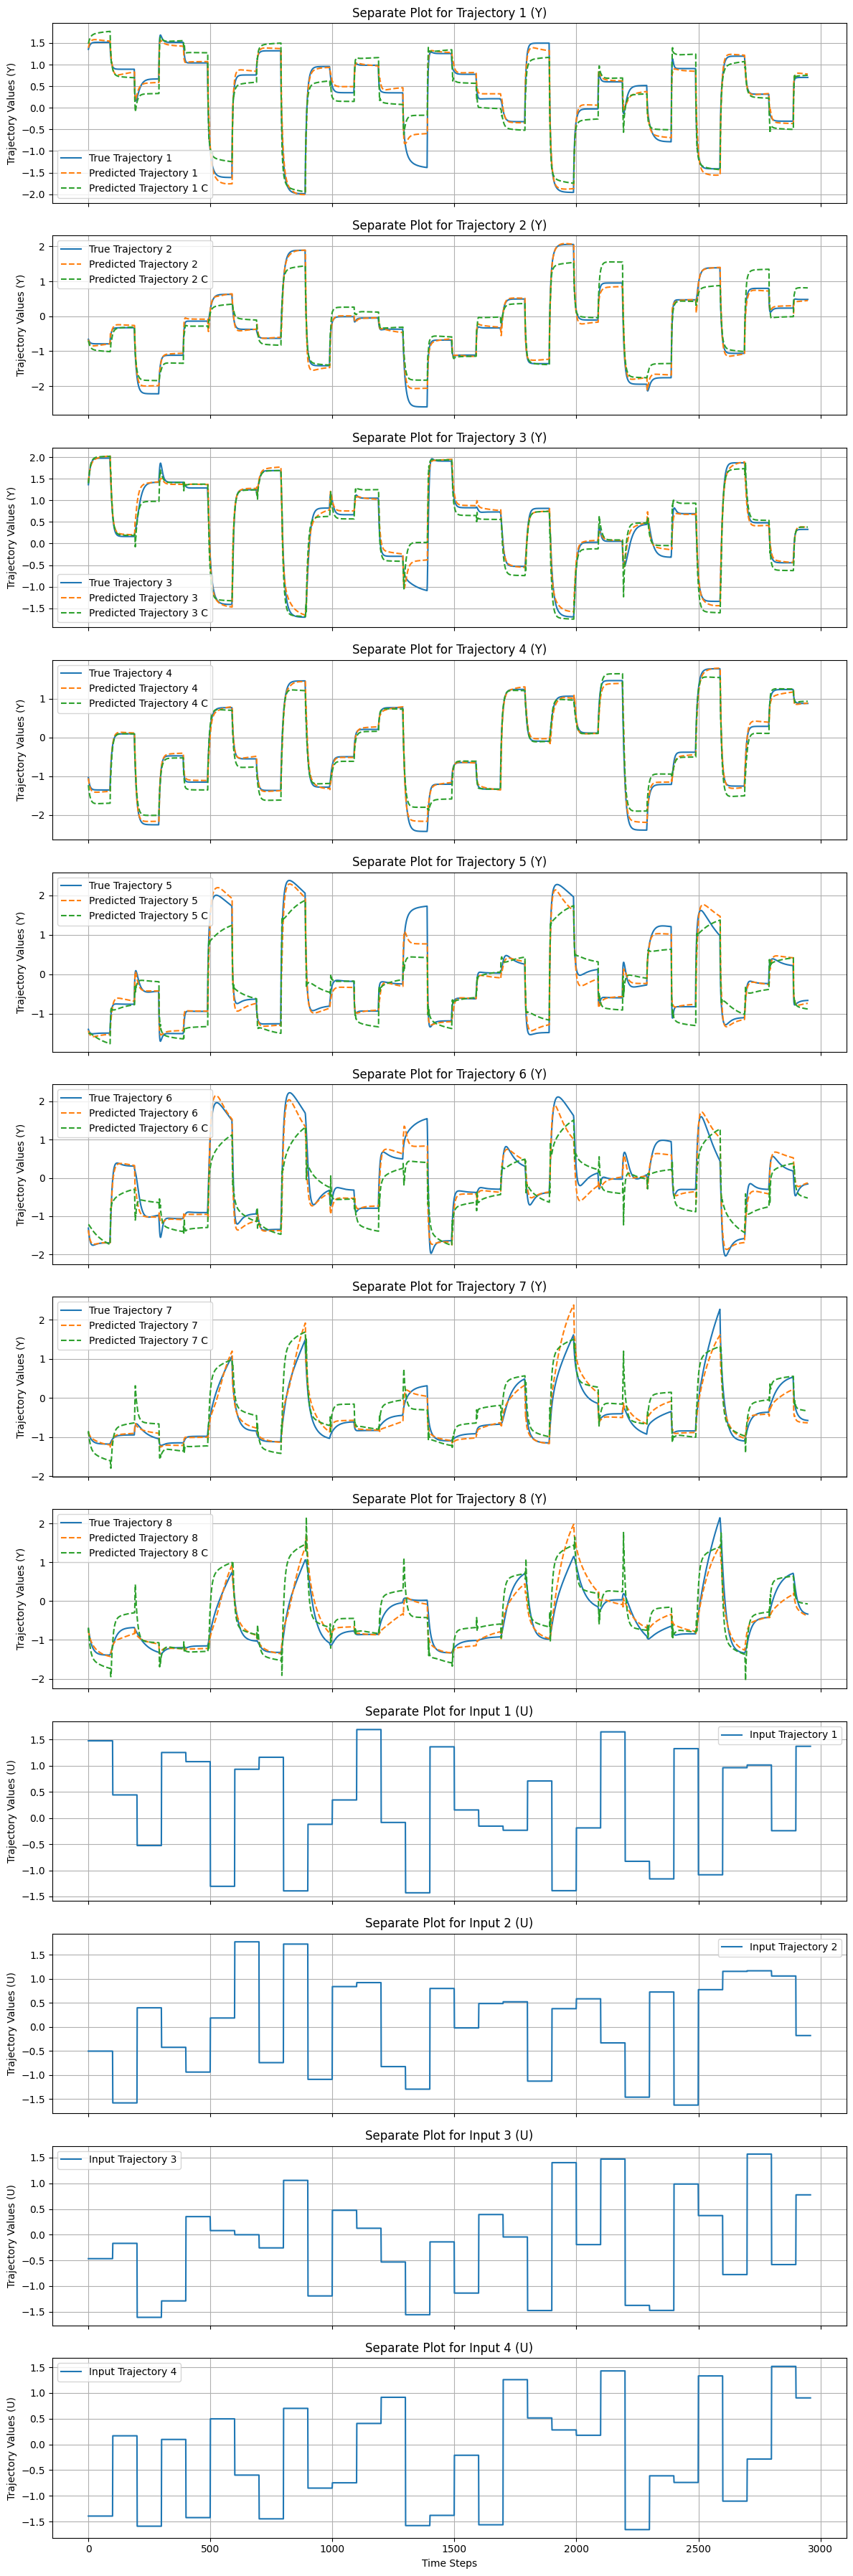

In [36]:
fig, axs = plt.subplots(ny + nu, 1, figsize=(12, 3 * (ny + nu)), sharex=True)

# Separate plots for each vector in Y
for i in range(ny):
    axs[i].plot(true_traj[i][10:], label=f'True Trajectory {i + 1}', linestyle='-')
    axs[i].plot(pred_traj[i][10:], label=f'Predicted Trajectory {i + 1}', linestyle='--')
    axs[i].plot(pred_traj_C[i][10:], label=f'Predicted Trajectory {i + 1} C', linestyle='--')
    #axs[i].plot(pred_traj_J[i], label=f'Predicted Trajectory {i + 1} J', linestyle='--')
    axs[i].set_title(f'Separate Plot for Trajectory {i + 1} (Y)')
    axs[i].legend()
    axs[i].grid()

# Separate plots for each vector in U
for i in range(nu):
    axs[ny + i].plot(input_traj[i], label=f'Input Trajectory {i + 1}', linestyle='-')
    axs[ny + i].set_title(f'Separate Plot for Input {i + 1} (U)')
    axs[ny + i].legend()
    axs[ny + i].grid()

# Add labels
axs[-1].set_xlabel('Time Steps')
for i in range(ny):
    axs[i].set_ylabel('Trajectory Values (Y)')
for i in range(nu):
    axs[ny + i].set_ylabel('Trajectory Values (U)')

plt.tight_layout()
plt.show()


In [ ]:
# calculate MAE of predicted trajectories
mae_pred = np.mean(np.abs(true_traj - pred_traj), axis=1)
mae_pred_C = np.mean(np.abs(true_traj - pred_traj_C), axis=1)
mae_pred_J = np.mean(np.abs(true_traj - pred_traj_J), axis=1)
print(f'MAE of predicted trajectory: {sum(mae_pred)}')
print(f'MAE of predicted trajectory C: {sum(mae_pred_C)}')
print(f'MAE of predicted trajectory J: {sum(mae_pred_J)}')

MAE of predicted trajectory: 1.0492975041270256
MAE of predicted trajectory C: 1.7937734574079514
MAE of predicted trajectory J: 3.649141941363206


In [ ]:
# Define lower and upper bounds for true_traj values
lower_bound = -0.01
upper_bound = 0.01

# Create mask for values within the specified range
mask = (true_traj >= lower_bound) & (true_traj <= upper_bound)

# Compute MAE only for masked values
mae_pred_masked = [np.mean(np.abs(true_traj[i][mask[i]] - pred_traj[i][mask[i]])) for i in range(true_traj.shape[0])]
mae_pred_C_masked = [np.mean(np.abs(true_traj[i][mask[i]] - pred_traj_C[i][mask[i]])) for i in range(true_traj.shape[0])]
mae_pred_J_masked = [np.mean(np.abs(true_traj[i][mask[i]] - pred_traj_J[i][mask[i]])) for i in range(true_traj.shape[0])]

print(f'Masked MAE of predicted trajectory: {sum(mae_pred_masked)}')
print(f'Masked MAE of predicted trajectory C: {sum(mae_pred_C_masked)}')
print(f'Masked MAE of predicted trajectory J: {sum(mae_pred_J_masked)}')

Masked MAE of predicted trajectory: 1.3738160962238908
Masked MAE of predicted trajectory C: 1.6461055353283882
Masked MAE of predicted trajectory J: 2.0001645804010115


In [ ]:
J_mean

array([[ 1.51786417e-01,  2.14629471e-01, -1.72038332e-01,
         3.31208855e-02, -5.82647026e-02,  1.59149453e-01,
        -7.63604343e-02,  1.54088121e-02, -1.35167480e-01,
        -6.15533628e-02, -2.98784543e-02,  5.12115099e-02,
         1.50204107e-01,  1.13156915e-01,  2.66707093e-01,
        -1.78405330e-01, -6.41389117e-02, -1.14181697e-01,
         2.34279186e-01,  6.62056506e-02,  7.31766522e-02,
        -1.09248437e-01,  4.23187613e-02, -1.30568489e-01,
         5.24384491e-02, -8.51319060e-02,  9.84302610e-02,
        -1.20953307e-01, -1.00860577e-02, -1.17761061e-01,
         1.08552873e-02, -5.09662889e-02,  1.08574115e-01,
        -2.16739383e-02, -1.46965191e-01,  6.11680374e-02],
       [ 1.23076230e-01, -8.80622957e-03, -1.07651651e-01,
        -1.39310554e-01,  4.99802679e-02, -2.10870907e-01,
         5.57780564e-02,  4.00885828e-02,  2.35608630e-02,
         5.34528941e-02, -1.58185303e-01, -2.64358342e-01,
         8.64724666e-02, -5.67871258e-02, -1.77435815e-

In [ ]:
C

array([[ -5.009563  ,  -6.680163  ,  -2.467164  ,   1.0921354 ,
         -0.63646793, -10.534301  ,  -1.6128988 ,   7.3529596 ,
         14.12062   ,  -2.907232  , -19.774143  ,  -1.9531361 ,
        -10.985276  ,  -0.6216966 ,   7.3182364 ,  12.454911  ,
         -1.7648615 ,   7.6321135 ,   4.851565  ,   3.9854832 ,
         -3.4596736 , -17.168922  ,   7.6179886 ,  17.005346  ,
          9.194613  , -10.534124  ,   3.6639402 ,  -1.3216672 ,
         -3.7087333 ,  -3.4335477 ,  -5.7716627 ,  -5.165591  ,
         20.312435  ,   3.6070302 ,   2.8565786 ,   0.20808823],
       [  3.6466386 ,   7.6625624 ,   1.427218  ,  -7.858935  ,
         -3.8994792 ,   9.226647  ,   3.6991463 ,  -4.964462  ,
        -19.027946  ,   8.608002  ,   9.926232  ,  -3.453029  ,
          8.972091  ,  -8.069301  ,   1.0330715 ,  -3.955003  ,
          1.015261  ,  -7.7481923 ,  -5.926013  ,   4.2646055 ,
         -4.1634045 ,   9.218635  , -15.236723  ,  -8.19313   ,
          0.31445432,   4.6348023 , -11

In [ ]:
# mse C-J
mse_C_J = np.mean((C - J_mean) ** 2)
print("Mean Squared Error between C and J_mean:\n", mse_C_J)
# mse C-J
mse_C_J = np.mean((C - J) ** 2)
print("Mean Squared Error between C and J:\n", mse_C_J)

Mean Squared Error between C and J_mean:
 179.77357
Mean Squared Error between C and J:
 179.84178


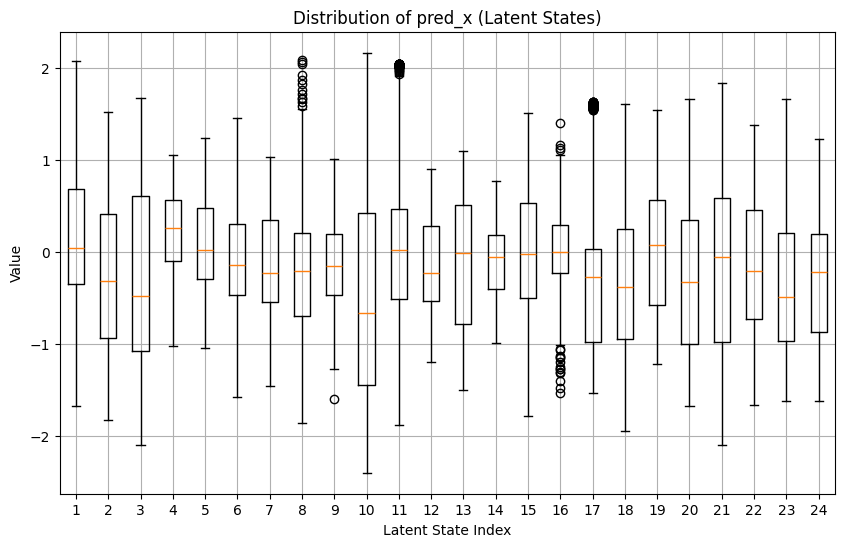

In [37]:
plt.figure(figsize=(10, 6))
plt.boxplot(pred_x.T)
plt.title('Distribution of pred_x (Latent States)')
plt.xlabel('Latent State Index')
plt.ylabel('Value')
plt.grid(True)
plt.show()

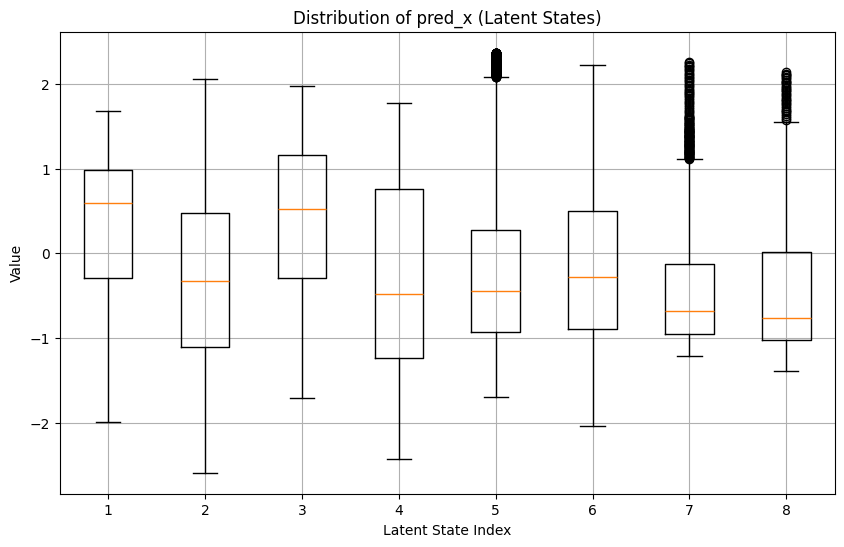

In [39]:
plt.figure(figsize=(10, 6))
plt.boxplot(true_traj.T)
plt.title('Distribution of pred_x (Latent States)')
plt.xlabel('Latent State Index')
plt.ylabel('Value')
plt.grid(True)
plt.show()

In [43]:

true_traj_descaled = scaler.inverse_transform(true_traj.T)
for i in range(8):
    min_true_traj_descaled = np.min(true_traj_descaled[:,i])
    max_true_traj_descaled = np.max(true_traj_descaled[:,i])
    print(f"Descaled min of true_traj {i}:", min_true_traj_descaled)
    print(f"Descaled max of true_traj {i}:", max_true_traj_descaled)


Descaled min of true_traj 0: 3.7700365
Descaled max of true_traj 0: 54.478035
Descaled min of true_traj 1: 282.57596
Descaled max of true_traj 1: 319.5093
Descaled min of true_traj 2: 2.5636313
Descaled max of true_traj 2: 34.511612
Descaled min of true_traj 3: 282.0993
Descaled max of true_traj 3: 319.3196
Descaled min of true_traj 4: 20.690596
Descaled max of true_traj 4: 42.07516
Descaled min of true_traj 5: 29.117628
Descaled max of true_traj 5: 42.61236
Descaled min of true_traj 6: 1.5366039
Descaled max of true_traj 6: 16.612625
Descaled min of true_traj 7: 2.4926567
Descaled max of true_traj 7: 18.056665


(2959, 8)